In [1]:
import torch
from torch import nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import numpy as np
from IPython import display
from matplotlib import pyplot as plt

In [2]:
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

In [148]:
trainset = ImageFolder(root='.', transform=transform)
train_data = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)


In [4]:
z = 500
class Decoder(nn.Module):
    '''
        Generative Network
    '''
    def __init__(self, z_size=z, out_size=3, ngf=192):
        super(Decoder, self).__init__()
        self.z_size = z_size
        self.ngf = ngf
        self.out_size = out_size

        self.main = nn.Sequential(
            # input size is z_size
            nn.ConvTranspose2d(self.z_size, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(inplace=True),
            # state size: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(inplace=True),
            # state size: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(inplace=True),
            # state size: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(inplace=True),
            # state size: ngf x 32 x 32
            nn.ConvTranspose2d(self.ngf, self.out_size, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: out_size x 64 x 64
        )

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input):

        output = self.main(input)

        return output
    

class Encoder(nn.Module):
    '''
        Discriminative Network
    '''
    def __init__(self, in_size=3, ndf=192):
        super(Encoder, self).__init__()
        self.in_size = in_size
        self.ndf = ndf

        self.main = nn.Sequential(
            # input size is in_size x 64 x 64
            nn.Conv2d(self.in_size, self.ndf, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            # state size: ndf x 32 x 32
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.ReLU(inplace=True),
            # state size: (ndf * 2) x 16 x 16
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.ReLU(inplace=True),
            # state size: (ndf * 4) x 8 x 8
            nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 8),
            nn.ReLU(inplace=True),
            # state size: (ndf * 8) x 4 x 4
            nn.Conv2d(self.ndf * 8, z, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size: 1 x 1 x 1
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input):

        output = self.main(input)

        return output
    
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [5]:
model = CAE()

In [6]:
model(next(iter(train_data))[0])

tensor([[[[ 1.6175e-02,  1.6971e-01,  8.0119e-02,  ...,  1.0223e-01,
            7.0689e-03,  9.1624e-03],
          [ 5.9021e-02,  5.9321e-02,  4.5789e-02,  ...,  6.2758e-02,
            8.5033e-03, -6.6335e-02],
          [ 3.6036e-02,  2.9526e-02,  7.2083e-03,  ..., -1.0197e-02,
           -1.9834e-01, -1.8575e-02],
          ...,
          [-8.9188e-02, -3.9332e-02, -4.5633e-02,  ...,  9.0282e-02,
            1.0048e-01, -3.4852e-02],
          [ 1.3254e-02,  2.5782e-01, -8.4982e-02,  ...,  1.9134e-01,
           -1.7596e-01, -2.2290e-02],
          [-4.6190e-02,  2.8953e-02, -6.5105e-02,  ...,  4.9440e-02,
           -1.2169e-02, -1.4772e-02]],

         [[ 6.8783e-02,  4.3373e-02,  2.0338e-02,  ...,  1.7234e-02,
            1.5269e-02, -8.9105e-03],
          [-4.1302e-02,  8.9127e-02, -1.0139e-01,  ...,  1.6139e-01,
            1.5885e-02,  2.8158e-02],
          [-3.9603e-02, -3.6963e-03, -4.9058e-02,  ..., -1.8456e-01,
            6.6880e-03,  7.3085e-02],
          ...,
     

In [7]:
train_loss, val_acc, train_acc = list(), list(), list()

network = CAE()
params = [param for param in network.parameters() if param.requires_grad]
optimizer = torch.optim.Adam(params)
# criterion = nn.CrossEntropyLoss()
epoch = 0
mse_criterion = nn.MSELoss()
ce_criterion = nn.CrossEntropyLoss()

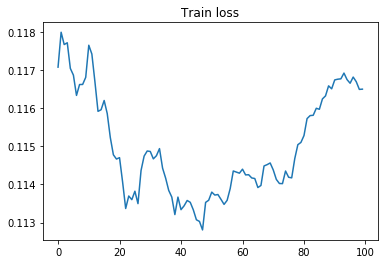

Loss: 0.11649751643939264


In [ ]:
while True:
    print("Epoch", epoch)
    network.train(True)
    
    epoch_loss = []
    
    for X_batch in train_data:
        X_batch = X_batch[0]
        reconstruction = network(Variable(X_batch))
        r_loss = mse_criterion(reconstruction, X_batch)
        
        loss = 10*r_loss

        # train on batch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        try:
            epoch_loss.append(loss.data.item())
        except:
            epoch_loss.append(loss.data.numpy()[0])

        train_loss.append(np.mean(epoch_loss))
            
        plt.clf()
        plt.plot(train_loss[-100:])
        plt.title('Train loss')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())

        print("Loss: {}".format(train_loss[-1]))
        
        epoch += 1

In [ ]:
40*31*23*64

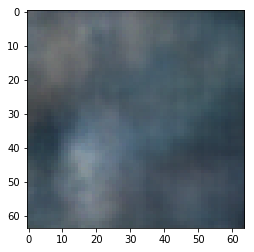

In [186]:
c = next(iter(train_data))[0]
a = network(c)
# print(a)
a = a[0].permute(1, 2, 0)

# print(a.shape)
a = a.cpu().detach().numpy()
b = np.clip(a, 0, 1)
plt.imshow(b)

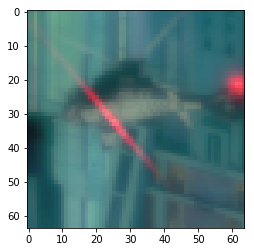

In [187]:
plt.imshow(c[0].permute(1, 2, 0))

In [126]:
from copy import deepcopy

model = deepcopy(network)

In [129]:
modules = list(iter(model.decoder.modules()))[1:]

In [130]:
modules

[Sequential(
   (0): ConvTranspose2d(500, 1536, kernel_size=(4, 4), stride=(1, 1), bias=False)
   (1): BatchNorm2d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): ConvTranspose2d(1536, 768, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
   (4): BatchNorm2d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU(inplace)
   (6): ConvTranspose2d(768, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
   (7): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): ReLU(inplace)
   (9): ConvTranspose2d(384, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
   (10): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): ConvTranspose2d(192, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
   (13): Tanh()
 ),
 ConvTranspose2d(500, 1536, kernel_size=(4, 4), st

In [132]:
# one = torch.zeros(1, 100)
it = 0
# p= torch.rand(1, 1000)
p = torch.zeros(1, 500, 1, 1)
p[0, np.random.randint(10)] = 1
while True:
    q = torch.rand(1, 500, 1, 1)
#     q = torch.zeros(1, 1000)
#     q[0, np.random.randint(00)] = 1

    relu = nn.ReLU()
    for i in np.arange(0, 1, 0.1):
    # one[0, 5]
        it += 1
        r = p*(1-i) + q*i
        x = modules[0](r)
        x = relu(x)
        x = x.view(1, , 8, 8)
        x = modules[1](x)

        x = modules[2](x)
        x = relu(x)
        x = modules[3](x)
        x = modules[4](x)
        x = relu(x)
        x = modules[5](x)
        x = modules[6](x)

        print(x[0].shape)
        a = x[0].permute(1, 2, 0)

        print(a.shape)
        a = a.cpu().detach().numpy()
        b = np.clip(a, 0, 1)
        
        display.clear_output(wait=True)
        plt.imshow(b)

#         fig, ax = plt.subplots(figsize=(3, 3))
# #         fig.savefig("{:4d}".format(it)+".png", dpi=fig.dpi)
#     #     plt.show()

        display.display(plt.gcf())
    p = q

RuntimeError: invalid argument 2: size '[1 x 40 x 8 x 8]' is invalid for input with 12288 elements at /pytorch/aten/src/TH/THStorage.c:41

In [ ]:
40*8*8

In [ ]:
torch.rand(1)

In [ ]:
y_onehot

In [ ]:
x.view(x.size(0), 1)

In [ ]:
t[[0, 1]]

In [ ]:
x.v

In [ ]:
t[[1,2, 3, 4]] = 1

In [ ]:
t[a, 0] = 1

In [ ]:
t

In [ ]:
optimizer.param_groups[0]['lr'] = 0.0001

In [110]:
import pickle

with open("cae2.pickle", "wb") as f:
    pickle.dump(network, f)

In [ ]:
import pickle

with open("cae2.pickle", "rb") as f:
    pickle.load(f)

In [ ]:
pickle.load(f)